In [3]:
import pandas as pd
import pickle

pkl_name = "exp_data\\jgp_alone\\expansion methods_4Q_1000N_20D\\results_D=20_Q=4_M=25_K=3_N=1000_noise_var=4_method=polynomial.pkl"
with open(pkl_name, "rb") as f:
    summary_table = pickle.load(f)
    print(summary_table)


{'1': {'JGP_SIR': [tensor(290.1468), tensor(131.2297), 8.308900117874146], 'JGP_RAW': [tensor(337.1208), tensor(159.2665), 43.294161319732666], 'DGP_0': [317.0786437988281, 297.848876953125, 27.765212774276733], 'LMJGP_0': [tensor(279.4799, device='cuda:0'), tensor(124.2638, device='cuda:0'), 109.14283680915833]}, '2': {'JGP_SIR': [tensor(267.8951), tensor(120.3152), 7.8609299659729], 'JGP_RAW': [tensor(270.9934), tensor(111.9709), 47.617098569869995], 'DGP_0': [301.346923828125, 272.17852783203125, 27.24110198020935], 'LMJGP_0': [tensor(289.4254, device='cuda:0'), tensor(134.0875, device='cuda:0'), 109.38439393043518]}, '3': {'JGP_SIR': [tensor(281.2639), tensor(116.9509), 8.605777025222778], 'JGP_RAW': [tensor(421.5443), tensor(230.2152), 40.876851320266724], 'DGP_0': [338.8435363769531, 322.46124267578125, 27.70531153678894], 'LMJGP_0': [tensor(327.5737, device='cuda:0'), tensor(155.4448, device='cuda:0'), 111.1729371547699]}, '4': {'JGP_SIR': [tensor(204.6920), tensor(68.7568), 8.1

In [30]:
import numpy as np
import torch
from collections import defaultdict

def remove_outliers_iqr(values):
    """使用IQR方法去除异常值"""
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in values if lower_bound <= x <= upper_bound]

def calculate_statistics(values):
    """计算统计指标"""
    values = np.array(values)
    return {
        'mean': float(np.mean(values)),
        # 'median': float(np.median(values)),
        # 'q25': float(np.percentile(values, 25)),
        # 'q75': float(np.percentile(values, 75)),
        # 'std': float(np.std(values, ddof=1))  
    }

def convert_to_float(value):
    """将tensor或其他类型转换为float"""
    if isinstance(value, torch.Tensor):
        return float(value.cpu())
    return float(value)

def analyze_data(data):
    """分析数据并返回统计结果"""
    methods = ['JGP_SIR', 'JGP_RAW', 'DGP_0', 'LMJGP_0']
    results = {}
    rmses = {}
    crpss = {}
    runtimes = {}
    
    for method in methods:
        # 提取每种方法的RMSE、CRPS和runtime值
        rmse_values = []
        crps_values = []
        runtime_values = []
        
        for exp_key in data.keys():
            if method in data[exp_key]:
                values = data[exp_key][method]
                rmse_values.append(convert_to_float(values[0]))  # RMSE
                crps_values.append(convert_to_float(values[1]))  # CRPS
                runtime_values.append(convert_to_float(values[2]))  # Runtime
        
        # 去除RMSE和CRPS的异常值
        rmse_no_outliers = remove_outliers_iqr(rmse_values)
        crps_no_outliers = remove_outliers_iqr(crps_values)
        
        # 计算统计指标
        # results[method] = {
        #     'rmse': calculate_statistics(rmse_no_outliers),
        #     'crps': calculate_statistics(crps_no_outliers),
        #     'runtime_mean': np.mean(runtime_values)
        # }

        rmses[method] = calculate_statistics(rmse_no_outliers)
        crpss[method] = calculate_statistics(crps_no_outliers)
        runtimes[method] = np.mean(runtime_values)
        
        # 打印去除的异常值信息
        rmse_outliers = len(rmse_values) - len(rmse_no_outliers)
        crps_outliers = len(crps_values) - len(crps_no_outliers)
        if rmse_outliers > 0 or crps_outliers > 0:
            print(f"{method}: 去除了 {rmse_outliers} 个RMSE异常值, {crps_outliers} 个CRPS异常值")
    
    return rmses, crpss, runtimes

In [31]:
def deal_summary_table(pkl_name, vis=False):
    with open(pkl_name, "rb") as f:
        summary_table = pickle.load(f)
        print(summary_table)
    rmses, crpss, runtimes = analyze_data(summary_table)

    if vis:
        print("\n=== 分析结果 ===")
        for method, stats in analysis_results.items():
            print(f"\n{method}:")
            print(f"  RMSE统计 (去除异常值后):")
            print(f"    均值: {stats['rmse']['mean']:.4f}")
            print(f"    中位数: {stats['rmse']['median']:.4f}")
            print(f"    25分位数: {stats['rmse']['q25']:.4f}")
            print(f"    75分位数: {stats['rmse']['q75']:.4f}")
            print(f"    标准差: {stats['rmse']['std']:.4f}")
            
            print(f"  CRPS统计 (去除异常值后):")
            print(f"    均值: {stats['crps']['mean']:.4f}")
            print(f"    中位数: {stats['crps']['median']:.4f}")
            print(f"    25分位数: {stats['crps']['q25']:.4f}")
            print(f"    75分位数: {stats['crps']['q75']:.4f}")
            print(f"    标准差: {stats['crps']['std']:.4f}")
            
            print(f"  运行时间均值: {stats['runtime_mean']:.4f}")

        # 返回字典格式的结果
        print(f"\n=== 字典格式结果 ===")
        print("analysis_results =", analysis_results)

    return rmses, crpss, runtimes

In [32]:
total_rmses = {}
total_crpss = {}
total_runtimes = {}
for D,Q,N,K in [(20, 4,1000,3), (30, 5,1000,5), (50, 7,2000,5)]:
    for method in ["random projection", "rff", "autoencoder", "polynomial"]:
        M = 25
        if D==50:
            M = 35
        pkl_name = f"exp_data\\jgp_alone\\expansion methods_{Q}Q_{N}N_{D}D\\results_D={D}_Q={Q}_M={M}_K={K}_N={N}_noise_var=4_method={method}.pkl"
        rmses, crpss, runtimes = deal_summary_table(pkl_name)
        total_rmses[(D,Q,N,method)] = rmses
        total_crpss[(D,Q,N,method)] = crpss
        total_runtimes[(D,Q,N,method)] = runtimes


{'1': {'JGP_SIR': [tensor(395.2795), tensor(225.4047), 9.802966356277466], 'JGP_RAW': [tensor(317.9977), tensor(154.5228), 53.6517767906189], 'DGP_0': [320.71197509765625, 300.2898864746094, 27.557517766952515], 'LMJGP_0': [tensor(270.3115, device='cuda:0'), tensor(120.7186, device='cuda:0'), 112.96086120605469]}, '2': {'JGP_SIR': [tensor(352.8820), tensor(184.7624), 11.330663204193115], 'JGP_RAW': [tensor(267.9082), tensor(113.0887), 57.20496964454651], 'DGP_0': [286.4406433105469, 262.7964172363281, 27.51263689994812], 'LMJGP_0': [tensor(275.8792, device='cuda:0'), tensor(124.6899, device='cuda:0'), 107.95248460769653]}, '3': {'JGP_SIR': [tensor(433.4481), tensor(253.2284), 11.51334524154663], 'JGP_RAW': [tensor(373.9376), tensor(184.2622), 51.41466569900513], 'DGP_0': [336.5396423339844, 320.0489501953125, 28.19056463241577], 'LMJGP_0': [tensor(352.9084, device='cuda:0'), tensor(170.7325, device='cuda:0'), 106.94991707801819]}, '4': {'JGP_SIR': [tensor(482.4803), tensor(308.2629), 1

In [41]:
import pandas as pd
import numpy as np

def save_sum(data):
    rows = []
    for (n, d, t, feat), models in data.items():
        for model, stats in models.items():
            value = round(stats['mean'], 2)
            rows.append({
                "N": n,
                "D": d,
                "T": t,
                "Feature": feat,
                "Model": model,
                "Mean": value
            })

    df_simple = pd.DataFrame(rows)
    return df_simple

from openpyxl import load_workbook
import pandas as pd
import os

def append_df_to_excel(filename, df, sheet_name):
    if not os.path.exists(filename):
        # 如果文件不存在，直接创建
        df.to_excel(filename, index=False, sheet_name=sheet_name)
    else:
        # 如果文件存在，加载并追加 sheet
        with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer:
            # 如果 sheet 已存在，避免重复写入
            if sheet_name in writer.book.sheetnames:
                print(f"Sheet '{sheet_name}' already exists. Skipping.")
            else:
                df.to_excel(writer, index=False, sheet_name=sheet_name)

# 导出到 Excel 文件
excel_path = "model_metrics_summary.xlsx"
for data, name in zip([total_rmses, total_crpss], ["rmses", "crpss"]):
    print(name)
    df = save_sum(data)
    df_wide = df.pivot_table(
        index=["N", "D", "T", "Feature"], 
        columns="Model", 
        values="Mean"
    ).reset_index()
    # df.to_excel(excel_path, index=False, sheet_name=name)
    append_df_to_excel(excel_path, df_wide, name)


rmses
crpss


In [44]:
L2_total_rmses = {}
L2_total_crpss = {}
L2_total_runtimes = {}

for method in ["random projection", "rff", "autoencoder", "polynomial"]:
    D,Q,N = 20, 2, 1000
    pkl_name = f"exp_data\\jgp_alone\\Phatom expansion methods_4caseno_1000N_20D_3K_2noise_std\\results_D=20_Q=2_M=25_K=3_N=1000_noise_var=4_method={method}.pkl"
    rmses, crpss, runtimes = deal_summary_table(pkl_name)
    L2_total_rmses[(D,Q,N,method)] = rmses
    L2_total_crpss[(D,Q,N,method)] = crpss
    L2_total_runtimes[(D,Q,N,method)] = runtimes

excel_path = "model_metrics_summary.xlsx"
for data, name in zip([L2_total_rmses, L2_total_crpss], ["rmses_L2", "crpss_L2"]):
    print(name)
    df = save_sum(data)
    df_wide = df.pivot_table(
        index=["N", "D", "T", "Feature"], 
        columns="Model", 
        values="Mean"
    ).reset_index()
    # df.to_excel(excel_path, index=False, sheet_name=name)
    append_df_to_excel(excel_path, df_wide, name)

{'1': {'JGP_SIR': [tensor(3.8548), tensor(2.0858), 10.946911334991455], 'JGP_RAW': [tensor(2.2741), tensor(1.2668), 35.14986205101013], 'DGP_0': [2.125478744506836, 1.2785072326660156, 13.660133361816406], 'LMJGP_0': [tensor(2.2717, device='cuda:0'), tensor(1.2639, device='cuda:0'), 83.37775659561157]}, '2': {'JGP_SIR': [tensor(2.8920), tensor(1.5896), 11.364725828170776], 'JGP_RAW': [tensor(2.4124), tensor(1.2964), 33.836730003356934], 'DGP_0': [1.9963470697402954, 1.194425106048584, 17.635164737701416], 'LMJGP_0': [tensor(2.0906, device='cuda:0'), tensor(1.1897, device='cuda:0'), 78.51894497871399]}, '5': {'JGP_SIR': [tensor(2.9881), tensor(1.6800), 12.679541110992432], 'JGP_RAW': [tensor(2.1544), tensor(1.2560), 35.04658818244934], 'DGP_0': [2.2206032276153564, 1.363632321357727, 13.236689805984497], 'LMJGP_0': [tensor(2.1519, device='cuda:0'), tensor(1.2397, device='cuda:0'), 80.2321138381958]}, '7': {'JGP_SIR': [tensor(2.9282), tensor(1.7155), 11.415759086608887], 'JGP_RAW': [tens

In [ ]:
import pandas as pd

rows = []
for (n, d, t, feat), models in nested_dict.items():
    for model, stats in models.items():
        value = round(stats['mean'], 2)
        rows.append({
            "N": n,
            "D": d,
            "T": t,
            "Feature": feat,
            "Model": model,
            "Mean": value
        })

df_simple = pd.DataFrame(rows)

# 导出为 Excel 文件
excel_file_path = "/mnt/data/mean_results_summary.xlsx"
df_simple.to_excel(excel_file_path, index=False)

import ace_tools as tools; tools.display_dataframe_to_user(name="Mean Results Summary", dataframe=df_simple)

excel_file_path


{(20, 4, 1000, 'random projection'): {'JGP_SIR': {'mean': 367.8801971435547},
  'JGP_RAW': {'mean': 297.3663360595703},
  'DGP_0': {'mean': 309.32163391113284},
  'LMJGP_0': {'mean': 283.59776306152344}},
 (20, 4, 1000, 'rff'): {'JGP_SIR': {'mean': 295.85650465223523},
  'JGP_RAW': {'mean': 302.99761352539065},
  'DGP_0': {'mean': 303.18529205322267},
  'LMJGP_0': {'mean': 268.075212097168}},
 (20, 4, 1000, 'autoencoder'): {'JGP_SIR': {'mean': 302.8442603217231},
  'JGP_RAW': {'mean': 361.7310562133789},
  'DGP_0': {'mean': 303.60308837890625},
  'LMJGP_0': {'mean': 271.3934393988715}},
 (20, 4, 1000, 'polynomial'): {'JGP_SIR': {'mean': 259.27080078125},
  'JGP_RAW': {'mean': 290.5006622314453},
  'DGP_0': {'mean': 314.38751525878905},
  'LMJGP_0': {'mean': 292.9669437408447}},
 (30, 5, 1000, 'random projection'): {'JGP_SIR': {'mean': 697.9341827392578},
  'JGP_RAW': {'mean': 642.7186111450195},
  'DGP_0': {'mean': 719.3982543945312},
  'LMJGP_0': {'mean': 652.3606414794922}},
 (30, 5,

In [45]:
pkl_list = []
for method in ["random projection", "rff", "autoencoder", "polynomial"]:
    D,Q,N = 20, 2, 1000
    pkl_name = f"exp_data\\jgp_alone\\Phatom expansion methods_4caseno_1000N_20D_3K_2noise_std\\results_D=20_Q=2_M=25_K=3_N=1000_noise_var=4_method={method}.pkl"
    pkl_list.append(pkl_name)

for D,Q,N,K in [(20, 4,1000,3), (30, 5,1000,5), (50, 7,2000,5)]:
    for method in ["random projection", "rff", "autoencoder", "polynomial"]:
        M = 25
        if D==50:
            M = 35
        pkl_name = f"exp_data\\jgp_alone\\expansion methods_{Q}Q_{N}N_{D}D\\results_D={D}_Q={Q}_M={M}_K={K}_N={N}_noise_var=4_method={method}.pkl"
        pkl_list.append(pkl_name)

In [53]:
import pandas as pd
from scipy.stats import rankdata

datas = []
for pkl_name in pkl_list:
    with open(pkl_name, "rb") as f:
        summary_table = pickle.load(f)
    datas.append(summary_table)

rank_df = []

idx = 1
for exp_idx, data in enumerate(datas):
    for repeat_id, models in data.items():
        scores = {}
        for model, values in models.items():
            rmse = values[idx].item() if isinstance(values[idx], torch.Tensor) else values[idx]
            scores[model] = rmse
        # 值越小越好，返回排名（1 表示最好）
        ranks = rankdata(list(scores.values()), method='average')
        rank_df.append({model: rank for model, rank in zip(scores.keys(), ranks)})

# 转换为 DataFrame，计算平均 rank score
rank_df = pd.DataFrame(rank_df)
mean_rank_score = rank_df.mean().sort_values()

mean_rank_score

LMJGP_0    1.481013
JGP_RAW    2.335443
JGP_SIR    2.379747
DGP_0      3.803797
dtype: float64

In [75]:
rmses = {}
for Q, K in ((q, k) for q in [3, 5, 7] for k in [2, 3, 5, 7]):
    pkl_name = f"exp_data/LH_hypertune_K_{Q}Q_1000N_30D_{K}K/results_D=30_Q={Q}_M=25_K={K}_N=1000_noise_var=4_method=rff.pkl"

    with open(pkl_name, "rb") as f:
        K_table = pickle.load(f)

    rmse = np.array([ v['LMJGP_0'][0].cpu().item() for k,v in K_table.items()])
    rmses[(Q, K)] = rmse

import matplotlib.pyplot as plt
import numpy as np

def plot_rmse_box_by_KQ(rmses: dict, output_file: str):
    """
    每个 subplot 对应一个 K，x 轴是 Q，画出 rmses[(K,Q)] 的 boxplot。
    所有 subplot 共享同一 y 轴刻度以便比较。
    """
    Ks = sorted({k for k, q in rmses.keys()})
    all_Qs = sorted({q for k, q in rmses.keys()})

    # 先汇总所有数据以确定统一的 y 轴范围（可选使用 percentile 除去极端值）
    all_values = np.concatenate([rmses[(K, Q)] for K, Q in rmses.keys()])
    y_lower, y_upper = np.percentile(all_values, [2, 98])  # 用 2%-98% 以减小极端值影响
    padding = 0.05 * (y_upper - y_lower)
    common_ylim = (max(0, y_lower - padding), y_upper + padding)

    num_K = len(Ks)
    fig, axes = plt.subplots(1, num_K, figsize=(5 * num_K, 5))
    if num_K == 1:
        axes = [axes]

    for ax, K in zip(axes, Ks):
        data = []
        labels = []
        for q in all_Qs:
            key = (K, q)
            if key in rmses:
                arr = np.asarray(rmses[key])
                data.append(arr)
                labels.append(str(q))
        if not data:
            continue

        bp = ax.boxplot(
            data,
            labels=labels,
            patch_artist=True,
            showfliers=False
        )

        # 统一样式
        for patch in bp["boxes"]:
            patch.set_facecolor("gray")
            patch.set_edgecolor("black")
        for whisker in bp["whiskers"]:
            whisker.set_color("black")
        for cap in bp["caps"]:
            cap.set_color("black")
        for median in bp["medians"]:
            median.set_color("cyan")
            median.set_linewidth(1.5)

        ax.set_title(f"$K={K}$")
        ax.set_xlabel("$Q$")
        # ax.set_ylim(common_ylim)  # 统一 y 轴
        ax.grid(True, axis="y", linestyle=":", alpha=0.7)
        if ax is axes[0]:
            ax.set_ylabel("RMSE")

    fig.suptitle("RMSE distributions over $Q$ for each $K$", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.close()
    print(f"Saved K–Q RMSE boxplots to {output_file}")




In [76]:
plot_rmse_box_by_KQ(rmses, "rmse_K_vs_Q_boxplot.png")


C:\Users\yxu59\AppData\Local\Temp\ipykernel_28048\2631616559.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\yxu59\AppData\Local\Temp\ipykernel_28048\2631616559.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\yxu59\AppData\Local\Temp\ipykernel_28048\2631616559.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


Saved K–Q RMSE boxplots to rmse_K_vs_Q_boxplot.png


In [74]:
crpss = {}
for Q, K in ((q, k) for q in [3, 5, 7] for k in [2, 3, 5, 7]):
    pkl_name = f"exp_data/LH_hypertune_K_{Q}Q_1000N_30D_{K}K/results_D=30_Q={Q}_M=25_K={K}_N=1000_noise_var=4_method=rff.pkl"

    with open(pkl_name, "rb") as f:
        K_table = pickle.load(f)

    crps = np.array([ v['LMJGP_0'][1].cpu().item() for k,v in K_table.items()])
    crpss[(Q, K)] = crps

import matplotlib.pyplot as plt
import numpy as np

def plot_rmse_box_by_KQ(rmses: dict, output_file: str):
    """
    每个 subplot 对应一个 K，x 轴是 Q，画出 rmses[(K,Q)] 的 boxplot。
    所有 subplot 共享同一 y 轴刻度以便比较。
    """
    Ks = sorted({k for k, q in rmses.keys()})
    all_Qs = sorted({q for k, q in rmses.keys()})

    # 先汇总所有数据以确定统一的 y 轴范围（可选使用 percentile 除去极端值）
    all_values = np.concatenate([rmses[(K, Q)] for K, Q in rmses.keys()])
    y_lower, y_upper = np.percentile(all_values, [2, 98])  # 用 2%-98% 以减小极端值影响
    padding = 0.05 * (y_upper - y_lower)
    common_ylim = (max(0, y_lower - padding), y_upper + padding)

    num_K = len(Ks)
    fig, axes = plt.subplots(1, num_K, figsize=(5 * num_K, 5))
    if num_K == 1:
        axes = [axes]

    for ax, K in zip(axes, Ks):
        data = []
        labels = []
        for q in all_Qs:
            key = (K, q)
            if key in rmses:
                arr = np.asarray(rmses[key])
                data.append(arr)
                labels.append(str(q))
        if not data:
            continue

        bp = ax.boxplot(
            data,
            labels=labels,
            patch_artist=True,
            showfliers=False
        )

        # 统一样式
        for patch in bp["boxes"]:
            patch.set_facecolor("gray")
            patch.set_edgecolor("black")
        for whisker in bp["whiskers"]:
            whisker.set_color("black")
        for cap in bp["caps"]:
            cap.set_color("black")
        for median in bp["medians"]:
            median.set_color("cyan")
            median.set_linewidth(1.5)

        ax.set_title(f"$K={K}$")
        ax.set_xlabel("$Q$")
        # ax.set_ylim(common_ylim)  # 统一 y 轴
        ax.grid(True, axis="y", linestyle=":", alpha=0.7)
        if ax is axes[0]:
            ax.set_ylabel("CRPS")

    fig.suptitle("CRPS distributions over $Q$ for each $K$", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_file, bbox_inches="tight", dpi=300)
    plt.close()
    print(f"Saved K–Q CRPS boxplots to {output_file}")

plot_rmse_box_by_KQ(crpss, "crps_K_vs_Q_boxplot.png")


C:\Users\yxu59\AppData\Local\Temp\ipykernel_28048\1593291068.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\yxu59\AppData\Local\Temp\ipykernel_28048\1593291068.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\yxu59\AppData\Local\Temp\ipykernel_28048\1593291068.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


Saved K–Q CRPS boxplots to crps_K_vs_Q_boxplot.png


In [89]:
rmses = {}
for M, m1 in ((q, k) for q in [15, 25, 35, 45] for k in [2, 4, 6]):
    pkl_name = f"exp_data\\LH_hypertune_Mm1_{M}M_{m1}m1_5Q_1000N_30D_5K\\results_method=rff.pkl"

    with open(pkl_name, "rb") as f:
        Mm1_table = pickle.load(f)

    rmse = np.array([ v['LMJGP_0'][1].cpu().item() for k,v in Mm1_table.items()])
    rmses[(M, m1)] = rmse


In [117]:
# LH_hypertune_m1m2_35M_2m1_20m2_5Q_1000N_30D_5K
rmses = {}
for m1, m2 in ((q, k) for q in [2, 4, 6] for k in [20, 40, 60]):
    pkl_name = f"exp_data\\LH_hypertune_m1m2_35M_{m1}m1_{m2}m2_5Q_1000N_30D_5K\\results_method=rff.pkl"

    with open(pkl_name, "rb") as f:
        Mm1_table = pickle.load(f)

    rmse = np.array([ v['LMJGP_0'][1].cpu().item() for k,v in Mm1_table.items()])
    rmses[(m1, m2)] = rmse

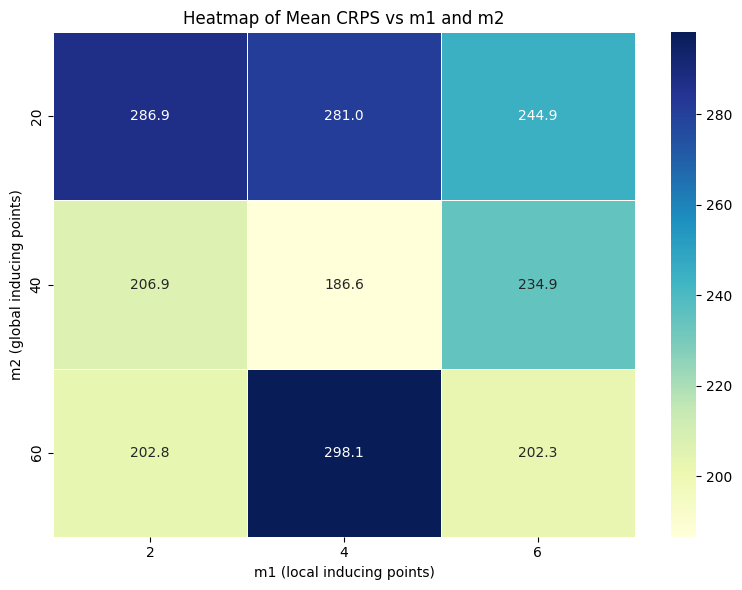

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

table = {}
for (q, k), values in rmses.items():
    table.setdefault(k, {})[q] = values.mean()

df = pd.DataFrame(table).T.sort_index()  # .T 转置是为了行：K，列：Q

# 画热力图
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)

# plt.title("Heatmap of Mean CRPS vs M and m1")
# plt.xlabel("M (neighbor size)")
# plt.ylabel("m1 (local inducing points)")
# plt.tight_layout()
# plt.savefig("crps_Mm1_heatmap.png")
plt.title("Heatmap of Mean CRPS vs m1 and m2")
plt.xlabel("m1 (local inducing points)")
plt.ylabel("m2 (global inducing points)")
plt.tight_layout()
plt.savefig("crps_m1m2_heatmap.png")
plt.show()


In [120]:
rmses = {}
for N, Q in ((q, k) for q in [1000, 3000, 5000, 10000] for k in [3, 4, 5, 6, 7]):
    pkl_name = f"exp_data\\LH_hypertune_NQ_35M_4m1_{Q}Q_{N}N_30D_5K\\results_method=rff.pkl"

    with open(pkl_name, "rb") as f:
        NQ_table = pickle.load(f)

    rmse = np.array([ v['LMJGP_0'][0].cpu().item() for k,v in NQ_table.items()]).mean()
    rmses[(N, Q)] = rmse

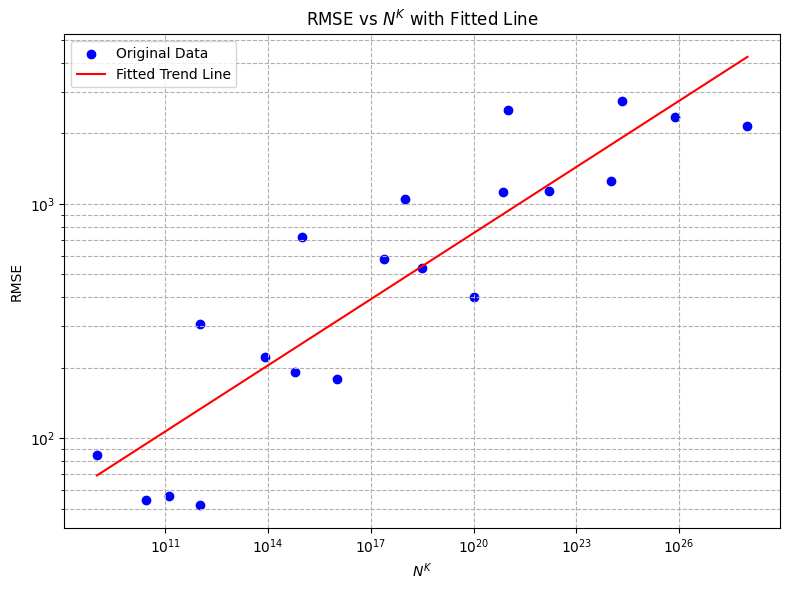

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# 原始数据
# data = {
#     (1000, 3): 84.73487243652343,
#     (1000, 5): 721.3432891845703,
#     (1000, 7): 2508.653192138672,
#     (3000, 3): 54.70913257598877,
#     (3000, 5): 580.7013610839844,
#     (3000, 7): 2750.2792724609376,
#     (5000, 3): 56.84606399536133,
#     (5000, 5): 531.8496398925781,
#     (5000, 7): 2356.489367675781,
#     (10000, 3): 51.778329372406006,
#     (10000, 5): 398.2666244506836,
#     (10000, 7): 2140.7505889892577
# }
data = rmses

# 提取 N^K 和对应的 value，注意转为 float 类型
x = np.array([float(n**k) for (n, k) in data.keys()])
y = np.array(list(data.values()))

# 对 x 和 y 做 log 变换，以便线性拟合
log_x = np.log(x)
log_y = np.log(y)

# 拟合直线：log(y) = a * log(x) + b
coeffs = np.polyfit(log_x, log_y, 1)
a, b = coeffs

# 用拟合结果生成预测值
x_fit = np.linspace(min(x), max(x), 100)
y_fit = np.exp(a * np.log(x_fit) + b)


# 绘图
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Original Data', color='blue')
plt.plot(x_fit, y_fit, label=f'Fitted Trend Line', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$N^K$')
plt.ylabel('RMSE')
plt.title(r'RMSE vs $N^K$ with Fitted Line')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


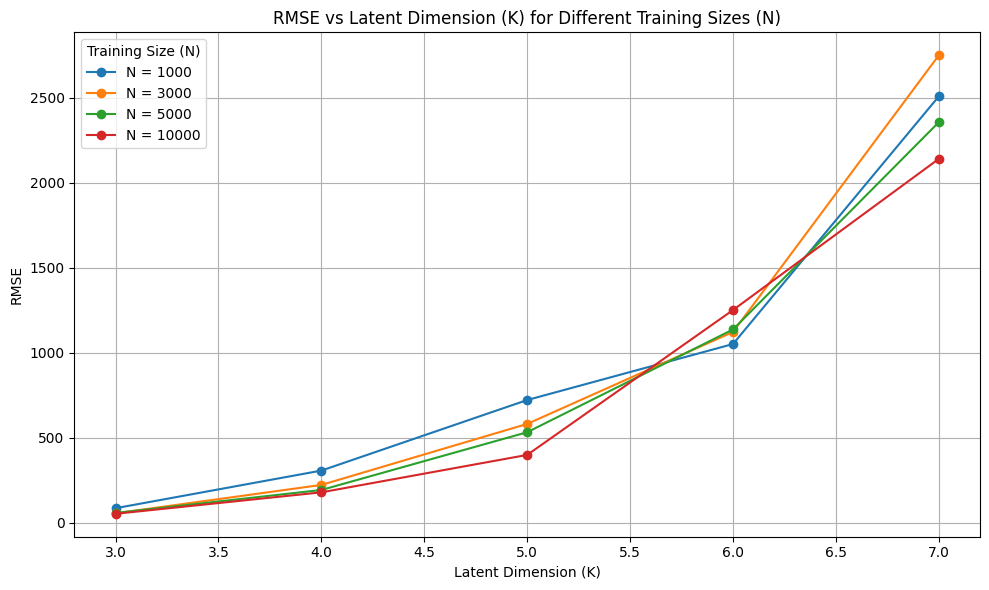

In [123]:
import matplotlib.pyplot as plt

# Raw data
data = rmses

# Organize data by N
organized_data = {}
for (N, D), rmse in data.items():
    if N not in organized_data:
        organized_data[N] = {'D': [], 'RMSE': []}
    organized_data[N]['D'].append(D)
    organized_data[N]['RMSE'].append(rmse)

# Plot
plt.figure(figsize=(10, 6))
for N in sorted(organized_data):
    D_vals = organized_data[N]['D']
    RMSE_vals = organized_data[N]['RMSE']
    plt.plot(D_vals, RMSE_vals, marker='o', label=f'N = {N}')

plt.xlabel('Latent Dimension (K)')
plt.ylabel('RMSE')
plt.title('RMSE vs Latent Dimension (K) for Different Training Sizes (N)')
plt.legend(title='Training Size (N)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [126]:
pkl_name = "UCI_dataset_analysis_res.pkl"
with open(pkl_name, "rb") as f:
    batch_table = pickle.load(f)

In [127]:
batch_table

{'Wine Quality':    sigma2_hat           snr  avg_grad (G)  max_grad (L)   tv2
 0     0.00001  25772.401376      0.326645       9.90099  8798,
 'Parkinsons Telemonitoring':    sigma2_hat           snr  avg_grad (G)  max_grad (L)        tv2
 0     0.00001  4.587641e+06      2.685015     56.833911  60871.747,
 'Appliances Energy Prediction':    sigma2_hat           snr  avg_grad (G)  max_grad (L)      tv2
 0    0.232145  12473.303936      6.459255    355.167517  2849220}

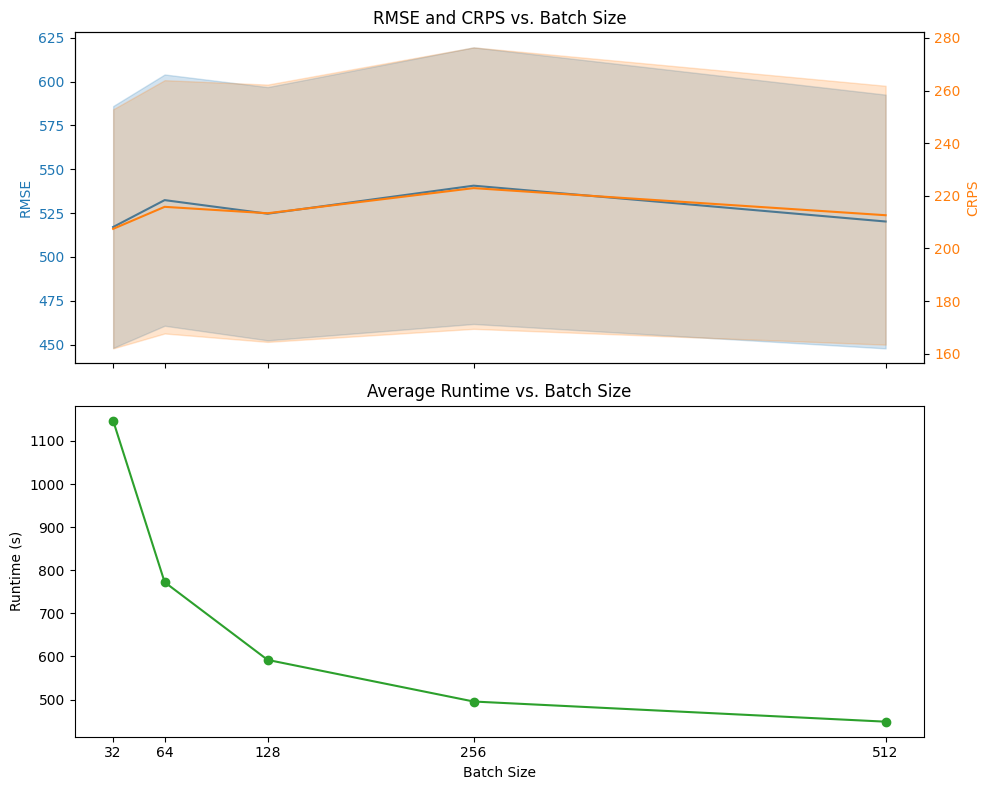

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Define the batch sizes
batch_sizes = np.array([32, 64, 128, 256, 512])

# Provided metrics for RMSE, CRPS, and time across 8 experiments
rmse_data = np.array([
    [656.05, 444.78, 707.23, 492.34, 336.65, 616.79, 305.82, 576.89],
    [686.18, 435.6, 708.75, 470.48, 347.52, 645.03, 333.88, 631.72],
    [708.8, 432.38, 715.87, 479.07, 342.79, 599.55, 320.74, 597.94],
    [710.95, 446.27, 770.78, 472.43, 345.18, 660.7, 322.45, 596.27],
    [660.12, 437.22, 737.14, 470.54, 346.43, 615.77, 303.34, 591.06]
])

crps_data = np.array([
    [307.99, 140.99, 335.4, 168.95, 93.56, 284.61, 90.07, 237.95],
    [326.37, 135.44, 334.27, 155.89, 97.86, 305.07, 101.79, 269.75],
    [344.33, 134.13, 343.06, 161.97, 95.52, 279.17, 95.93, 252.83],
    [341.29, 141.02, 383.29, 157.69, 97.26, 310.78, 95.7, 256.3],
    [315.55, 136.37, 362.11, 157.86, 97.19, 287.48, 90.18, 254.2]
])

time_data = np.array([
    [1126.92, 1171.2, 1128.09, 1155.07, 1161.6, 1117.48, 1173.25, 1142.39],
    [763.29, 791.73, 756.46, 791.74, 787.37, 740.55, 788.25, 758.51],
    [577.3, 609.22, 575.59, 605.3, 613.75, 557.82, 617.58, 578.83],
    [476.73, 519.97, 463.75, 514.93, 518.45, 457.79, 520.96, 490.29],
    [430.28, 468.99, 428.26, 470.1, 467.79, 418.33, 468.68, 436.44]
])

# Compute mean and std
rmse_mean, rmse_std = rmse_data.mean(axis=1), rmse_data.std(axis=1)
crps_mean, crps_std = crps_data.mean(axis=1), crps_data.std(axis=1)
time_mean = time_data.mean(axis=1)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top plot: RMSE and CRPS
ax1 = axes[0]
ax1.plot(batch_sizes, rmse_mean, label='RMSE', color='tab:blue')
ax1.fill_between(batch_sizes, rmse_mean - rmse_std/2, rmse_mean + rmse_std/2,
                 color='tab:blue', alpha=0.2)
ax1.set_ylabel("RMSE", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(batch_sizes, crps_mean, label='CRPS', color='tab:orange')
ax2.fill_between(batch_sizes, crps_mean - crps_std/2, crps_mean + crps_std/2,
                 color='tab:orange', alpha=0.2)
ax2.set_ylabel("CRPS", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.set_title("RMSE and CRPS vs. Batch Size")
ax1.set_xticks(batch_sizes)

# Bottom plot: Runtime
axes[1].plot(batch_sizes, time_mean, marker='o', color='tab:green')
axes[1].set_ylabel("Runtime (s)")
axes[1].set_title("Average Runtime vs. Batch Size")
axes[1].set_xlabel("Batch Size")
axes[1].set_xticks(batch_sizes)

plt.tight_layout()
plt.show()
